# Ungraded Lab: Training a Sarcasm Detection Model using a Convolution Layer

You will be doing the same steps here as the previous lab but will be using a convolution layer instead. As usual, try tweaking the parameters and observe how it affects the results.


## Download the Dataset

In [1]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

--2023-12-31 08:06:24--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf, 2607:f8b0:4023:c06::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  --.-KB/s    in 0.09s   

2023-12-31 08:06:25 (61.4 MB/s) - ‘sarcasm.json’ saved [5643545/5643545]



In [2]:
import json

# Load the JSON file
with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

## Split the Dataset

In [3]:
training_size = 20000

# Split the sentences
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

# Split the labels
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

## Data preprocessing

In [4]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

## Build and Compile the Model

In [5]:
import tensorflow as tf

# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171149 (668.55 KB)
Trainable params: 171149 (668.55 KB)
Non-trainable params: 0 (0.00 Byte)
________________

## Train the Model

In [6]:
NUM_EPOCHS = 2

# Train the model
history_conv = model_conv.fit(training_padded, training_labels, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels))

Epoch 1/2
625/625 [==============================] - 26s 24ms/step - loss: 0.4439 - accuracy: 0.7779 - val_loss: 0.3587 - val_accuracy: 0.8447
Epoch 2/2
625/625 [==============================] - 4s 7ms/step - loss: 0.2353 - accuracy: 0.9064 - val_loss: 0.3633 - val_accuracy: 0.8478


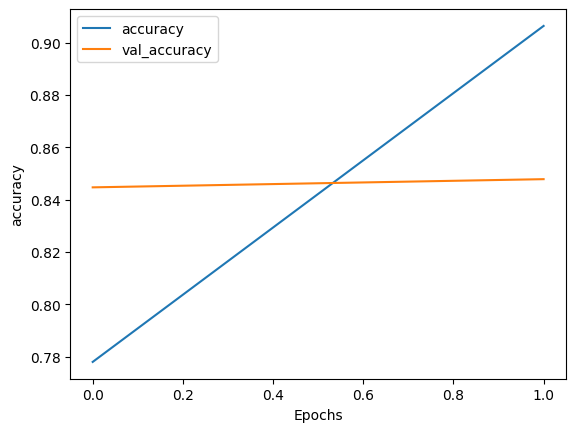

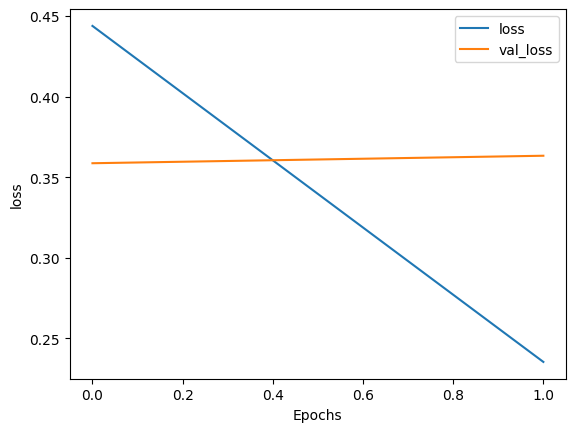

In [7]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(history_conv, 'accuracy')
plot_graphs(history_conv, 'loss')